# Flight Data Preprocessing

### Objective:
Explore 2016_1.csv to understand the flight data structure and decide which columns are worth keeping for a flight delay prediction task with weather integration.


#### Understanding the Nature of the Flight Data

Each row in the flight dataset represents one flight segment operated by a carrier on a specific date, with:

`scheduling information, actual operational timings, delay outcomes, delay causes, cancellation/diversion indicators`

The target variable (as per the task and common industry practice) is: `DepDel15`

- Whether a flight was delayed 15 minutes or more at departure (binary classification).

#### So every feature we keep must satisfy at least one of these:

- Predictive before departure
- Known at or before scheduled departure
- Strongly related to operational delay behavior
- Joinable with weather data

Columns We are using: 

| Column | Description |
| :--- | :--- |
| Year | Seasonality (fixed = 2016 but useful for structure) |
| Month | Strong seasonal delay patterns |
| DayofMonth | Travel cycles (mid-month vs end-month) |
| DayOfWeek | Weekday vs weekend traffic |
| FlightDate | Required to join with daily weather data |
| CRSDepTime | Scheduled departure time affects congestion |
| DepTimeBlk | Hourly traffic patterns |
| UniqueCarrier | Carrier-level operational behavior |
| Origin | Airport congestion + weather join key |
| Dest | Route complexity |
| Distance | Longer routes have different delay dynamics |
| DistanceGroup | Normalized distance buckets |
| Cancelled | Important to understand data loss patterns |
| Diverted | Operational abnormality indicator |
| DepDel15 | Prediction target (binary classification) |

### Load only required columns from `2016_1.csv` and perform Initial EDA

Load only the finalized columns from 2016_1.csv and perform light, purposeful EDA to validate data quality and feature behavior before filtering or cleaning.

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import os





# Selecting required fields
fields = [
    "Year",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "FlightDate",
    "CRSDepTime",
    "DepTimeBlk",
    "UniqueCarrier",
    "Origin",
    "Dest",
    "Distance",
    "DistanceGroup",
    "Cancelled",
    "Diverted",
    "DepDel15"
]

# Define the list of target airports for filtering
airports = ["ATL", "EWR", "JFK", "LAS", "LAX", "MCO", "MIA", "ORD", "SEA", "SFO"]

In [2]:
# Load flight data for January 2016 using specific columns
df_2016_1 = pd.read_csv("Data/Flight_Data/2016_1.csv", usecols=fields)

# Print the dimensions of the dataframe
print("Shape:", df_2016_1.shape)

# Display the first few rows of the dataframe
df_2016_1.head()

Shape: (445827, 15)


,Year,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,Origin,Dest,CRSDepTime,DepDel15,DepTimeBlk,Cancelled,Diverted,Distance,DistanceGroup
0,2016,1,6,3,2016-01-06,AA,DFW,DTW,1100,0.0,1100-1159,0.0,0.0,986.0,4
1,2016,1,7,4,2016-01-07,AA,DFW,DTW,1100,0.0,1100-1159,0.0,0.0,986.0,4
2,2016,1,8,5,2016-01-08,AA,DFW,DTW,1100,0.0,1100-1159,0.0,0.0,986.0,4
3,2016,1,9,6,2016-01-09,AA,DFW,DTW,1100,0.0,1100-1159,0.0,0.0,986.0,4
4,2016,1,10,7,2016-01-10,AA,DFW,DTW,1100,1.0,1100-1159,0.0,0.0,986.0,4


In [3]:
# Display information about the dataframe
df_2016_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445827 entries, 0 to 445826
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           445827 non-null  int64  
 1   Month          445827 non-null  int64  
 2   DayofMonth     445827 non-null  int64  
 3   DayOfWeek      445827 non-null  int64  
 4   FlightDate     445827 non-null  object 
 5   UniqueCarrier  445827 non-null  object 
 6   Origin         445827 non-null  object 
 7   Dest           445827 non-null  object 
 8   CRSDepTime     445827 non-null  int64  
 9   DepDel15       434354 non-null  float64
 10  DepTimeBlk     445827 non-null  object 
 11  Cancelled      445827 non-null  float64
 12  Diverted       445827 non-null  float64
 13  Distance       445827 non-null  float64
 14  DistanceGroup  445827 non-null  int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 51.0+ MB


### Target variable distribution (`DepDel15`)

In [4]:
# Count the frequency of unique values in 'DepDel15', including NaN values
df_2016_1["DepDel15"].value_counts(dropna=False)

DepDel15
0.0    363300
1.0     71054
NaN     11473
Name: count, dtype: int64

This confirms class imbalance (expected in delay prediction) and helps later with model choice and evaluation metrics

### Behaviour of `CRSDepTime`

In [5]:
# Display summary statistics for the scheduled departure time column
df_2016_1["CRSDepTime"].describe()

count    445827.000000
mean       1330.384387
std         482.809711
min           1.000000
25%         920.000000
50%        1325.000000
75%        1730.000000
max        2359.000000
Name: CRSDepTime, dtype: float64

CRSDepTime is stored as hhmm in numeric form and detects edge cases (midnight flights, missing values)

### Convert FlightDate to usable date format

In [6]:
# Convert FlightDate to string type to ensure consistent formatting for parsing
df_2016_1["FlightDate"] = df_2016_1["FlightDate"].astype(str)

# Parse the string date into a datetime object using the specified format
df_2016_1["date"] = pd.to_datetime(
    df_2016_1["FlightDate"],
    errors="coerce"
)

# Display the first few rows to verify the conversion results
df_2016_1[["FlightDate", "date"]].head()

,FlightDate,date
0,2016-01-06,2016-01-06
1,2016-01-07,2016-01-07
2,2016-01-08,2016-01-08
3,2016-01-09,2016-01-09
4,2016-01-10,2016-01-10


We don’t merge yet, but we standardize early

### Airport coverage (before filtering)

In [7]:
# Count the frequency of unique values in 'Origin', including NaN values
df_2016_1["Origin"].value_counts(dropna=False)

# Count the frequency of unique values in 'Dest', including NaN values
df_2016_1["Dest"].value_counts(dropna=False)

# Count the frequency of unique values in 'Origin', showing top 10 most common values
df_2016_1["Origin"].value_counts().head(10)


Origin
ATL    29870
ORD    18610
DEN    17519
DFW    16565
LAX    16427
SFO    13207
PHX    13024
LAS    12246
IAH    11660
MCO    10739
Name: count, dtype: int64

This insight confirms dataset is nationwide and justifies the need to filter to weather-supported airports in the next step

### Filter flights by required airports (Origin & Destination)

- Restrict the flight data to only those routes for which weather data is available, ensuring clean joins and no downstream missing weather values.


You have weather data only for these airports: `ATL, EWR, JFK, LAS, LAX, MCO, MIA, ORD, SEA, SFO`

In [8]:
# Check the initial number of records
print("Before filtering:", df_2016_1.shape)

# Filter for flights where both origin and destination are within the specified airport list
df_2016_1_filtered = df_2016_1[
    (df_2016_1["Origin"].isin(airports)) &
    (df_2016_1["Dest"].isin(airports))
].copy()

# Check the number of records after filtering
print("After filtering:", df_2016_1_filtered.shape)

# Verify the count of unique airports in the filtered dataset
print("Unique Origins:", df_2016_1_filtered["Origin"].nunique())
print("Unique Destinations:", df_2016_1_filtered["Dest"].nunique())


Before filtering: (445827, 16)
After filtering: (35596, 16)
Unique Origins: 10
Unique Destinations: 10


In [9]:
# Find unique origin and destination airports in the filtered 2016 data that are not in the reference airports list
set(df_2016_1_filtered["Origin"].unique()) - set(airports)
set(df_2016_1_filtered["Dest"].unique()) - set(airports)

set()

Above sanity checks after filtering verify whether flights are restricted to weather-supported routes

### Visualize missing data and understand patterns

Before dropping rows, we want to answer:
- Which columns have missing values?
- Is it random, or tied to cancellations/diversions?
- Will dropping rows destroy too much data?

#### Compute missing-value summary (counts with percent)

In [10]:
df = df_2016_1_filtered 

# Calculate the count and percentage of missing values for each column
missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_pct": (df.isna().sum() / len(df) * 100).round(2)
}).sort_values(by="missing_pct", ascending=False) # Sort by percentage in descending order

# Display the summary table
missing_summary


,missing_count,missing_pct
DepDel15,1020,2.87
Year,0,0.00
DayofMonth,0,0.00
Month,0,0.00
FlightDate,0,0.00
UniqueCarrier,0,0.00
Origin,0,0.00
DayOfWeek,0,0.00
Dest,0,0.00
CRSDepTime,0,0.00


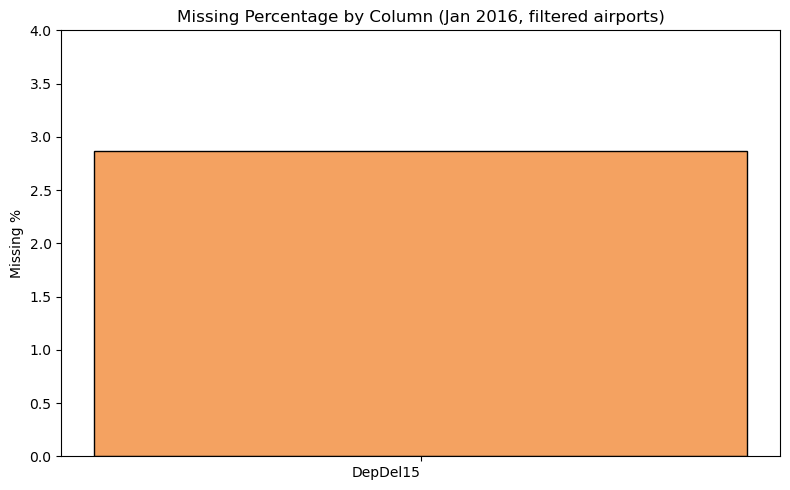

In [11]:
# Visualizing missing values
ms = missing_summary[missing_summary["missing_count"] > 0]

plt.figure(figsize=(8, 5))
plt.bar(ms.index, ms["missing_pct"],color="#F4A261",edgecolor="black")
plt.xticks(rotation=0, ha="right")
plt.ylim(0, 4)
plt.ylabel("Missing %")
plt.title("Missing Percentage by Column (Jan 2016, filtered airports)")
plt.tight_layout()
plt.show()

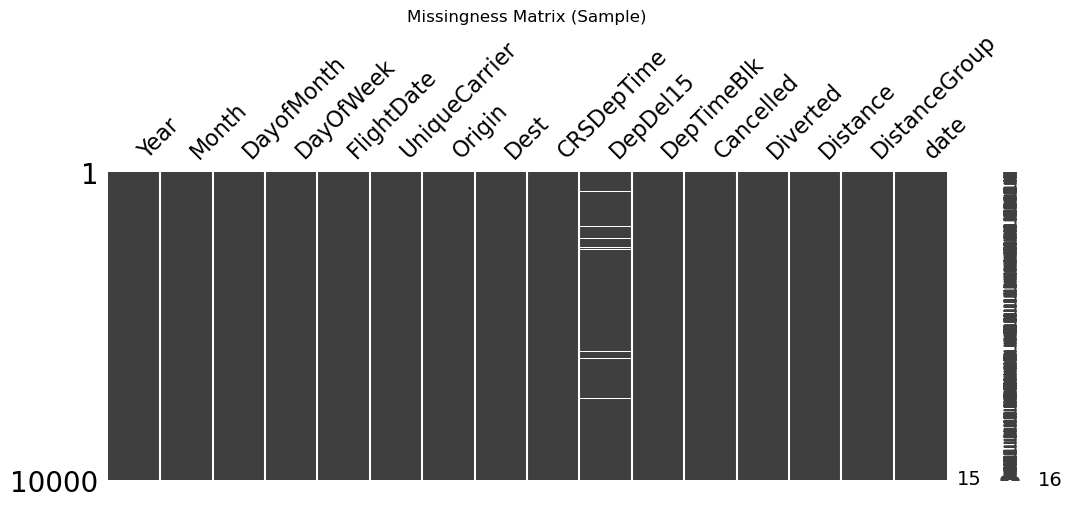

In [12]:
msno.matrix(df.sample(min(10000, len(df))), figsize=(12, 4))
plt.title("Missingness Matrix (Sample)")
plt.show()

DepDel15 has ~2–3% missing data. This happens in flight datasets when cancelled flights often have no departure delay label and some operational anomalies never receive a delay classification.

#### Missingness vs Cancelled/Diverted

In [13]:
def missing_rate_by_flag(df, flag_col):
    return (df.groupby(flag_col)
              .apply(lambda x: x.isna().mean() * 100)
              .round(2))

print("Missing % by Cancelled:")
display(missing_rate_by_flag(df, "Cancelled"))

print("\nMissing % by Diverted:")
display(missing_rate_by_flag(df, "Diverted"))


Missing % by Cancelled:


C:\Users\bgowt\AppData\Local\Temp\ipykernel_23956\2111821425.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.isna().mean() * 100)


,Year,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,Origin,Dest,CRSDepTime,DepDel15,DepTimeBlk,Cancelled,Diverted,Distance,DistanceGroup,date
Cancelled,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.84,0.0,0.0,0.0,0.0,0.0,0.0



Missing % by Diverted:


C:\Users\bgowt\AppData\Local\Temp\ipykernel_23956\2111821425.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.isna().mean() * 100)


,Year,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,Origin,Dest,CRSDepTime,DepDel15,DepTimeBlk,Cancelled,Diverted,Distance,DistanceGroup,date
Diverted,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.87,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


The data reveals a structural relationship between flight cancellations and missing values:
- **Cancelled (1):** 98.84% missing `DepDel15`.
- **Not Cancelled (0):** 0.00% missing `DepDel15`.
- Missingness in `DepDel15` is not random; it is structurally determined by cancellations, as departure delays are logically undefined for flights that never depart.

Analysis of diversion status shows no structural link to missing `DepDel15` values:
- **Diverted (1):** 0.00% missing `DepDel15`.
- **Not Diverted (0):** 2.87% missing `DepDel15`.
- Diversion is an in-flight event that occurs post-departure; therefore, departure delays are recorded for all diverted flights. Diversion status does not explain the missingness in the dataset.

#### Handle Missing Data

- Dropped rows with missing `DepDel15`

In [14]:
before = len(df)

df_clean = df.dropna(subset=["DepDel15"]).copy()

after = len(df_clean)

print(f"Rows before: {before}")
print(f"Rows after:  {after}")
print(f"Rows dropped: {before - after}")


Rows before: 35596
Rows after:  34576
Rows dropped: 1020


Axes(0.125,0.11;0.698618x0.77)


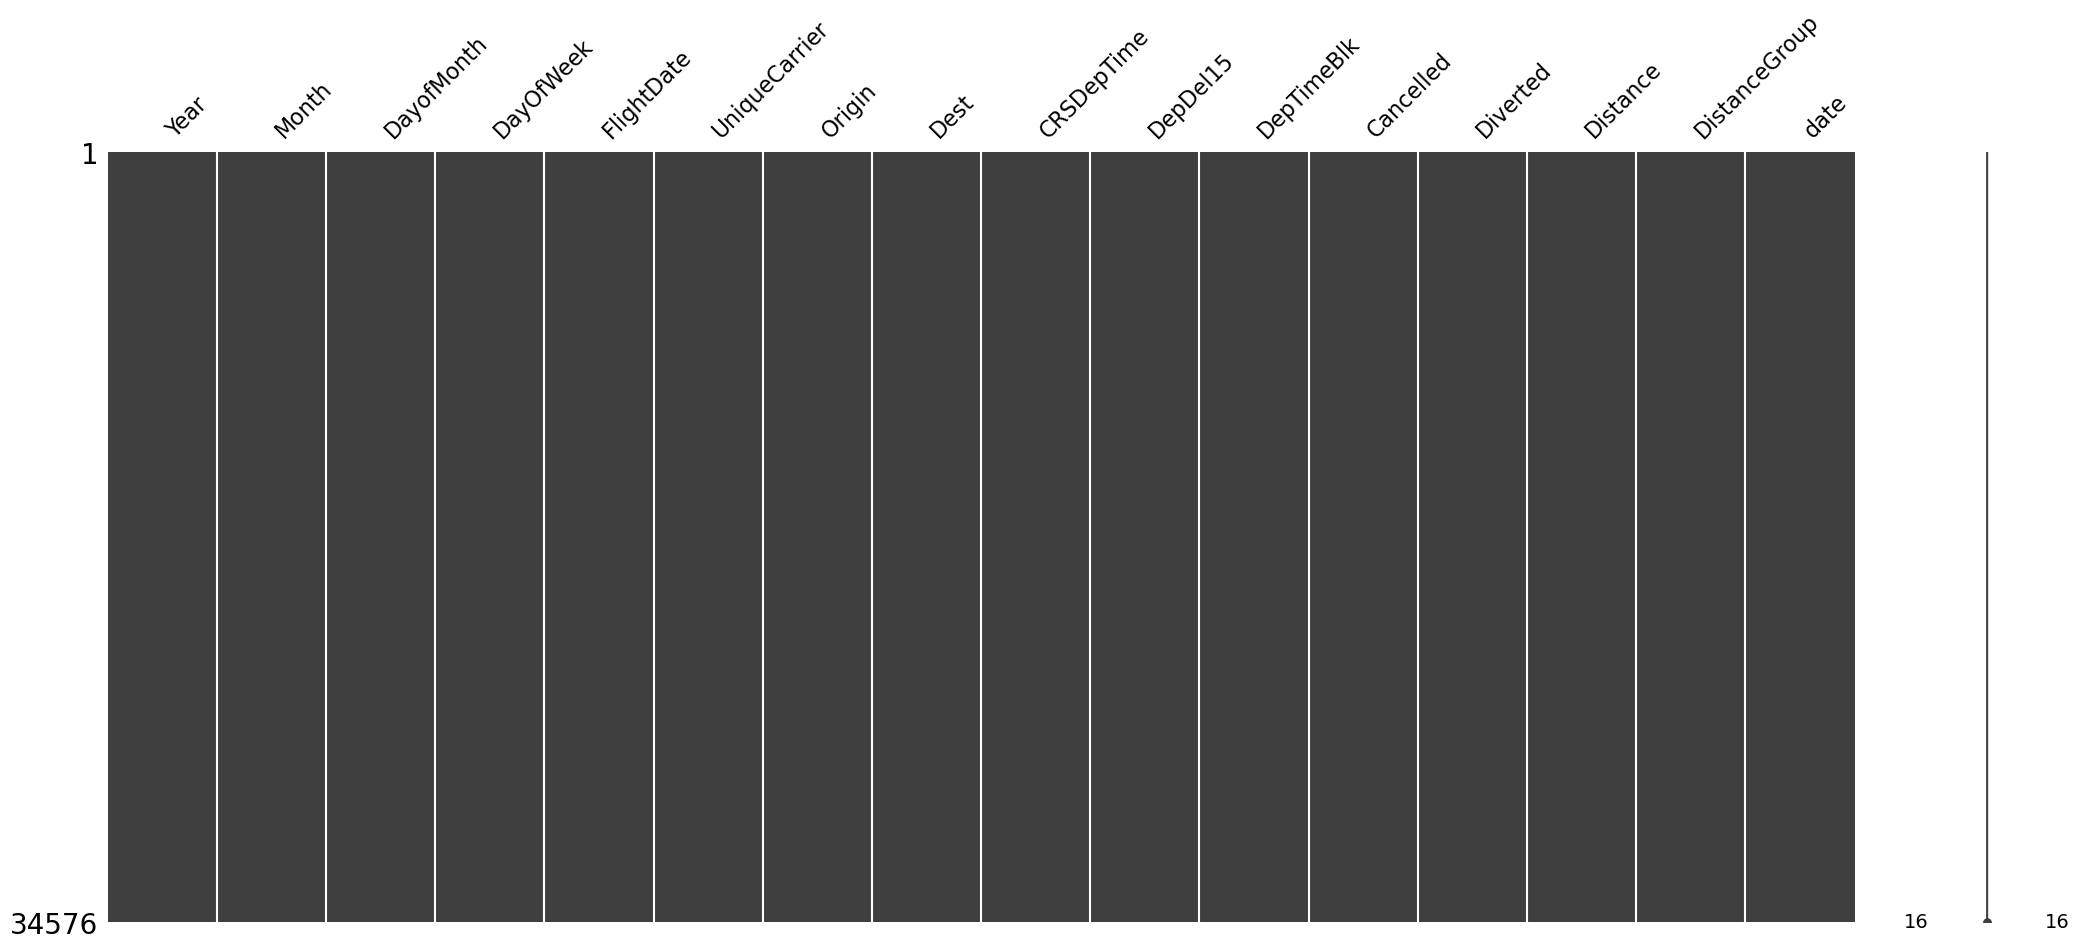

In [15]:
# No missing target
df_clean["DepDel15"].isna().sum()

# Cancelled flights remaining?
df_clean["Cancelled"].value_counts()

# Target distribution still valid
df_clean["DepDel15"].value_counts(normalize=True).round(3)


print(msno.matrix(df_clean))


Missing DepDel15 is structurally tied to cancelled flights (cancelled flights usually don’t have a departure delay label). And it’s a realistic imbalance for flight delay classification, and it’s fine for modeling, we’ll handle imbalance later via metrics/class weights if needed

### Load and combine all flight data

In [16]:
# Preprocessing function for handling flight data
def preprocess_flight_data(csv_path):
    df = pd.read_csv(csv_path, usecols=fields)
    
    # Filter to weather-supported airports
    df = df[
        (df["Origin"].isin(airports)) &
        (df["Dest"].isin(airports))
    ].copy()
    
    # Create date column correctly
    df["date"] = pd.to_datetime(df["FlightDate"], errors="coerce")
    
    # Drop rows with missing target
    df = df.dropna(subset=["DepDel15"]).copy()
    
    return df

In [17]:
flight_data_path = "Data/Flight_Data"

flight_data_files = sorted([
    os.path.join(flight_data_path, f)
    for f in os.listdir(flight_data_path)
    if f.endswith(".csv")
])

flight_data_files

['Data/Flight_Data\\2016_1.csv',
 'Data/Flight_Data\\2016_2.csv',
 'Data/Flight_Data\\2016_3.csv']

This process filters for CSV files using relative paths and sorts them to ensure reproducibility, while automatically scaling as additional monthly data is added.

In [18]:
processed_dfs = []

for file in flight_data_files:
    df_month = preprocess_flight_data(file)
    processed_dfs.append(df_month)
    print(f"{file.split('/')[-1]} : {df_month.shape}")

flight_data = pd.concat(processed_dfs, ignore_index=True)

print("Final combined shape:", flight_data.shape)

Flight_Data\2016_1.csv : (34576, 16)
Flight_Data\2016_2.csv : (33518, 16)
Flight_Data\2016_3.csv : (37689, 16)
Final combined shape: (105783, 16)


Loop through flight_data_files, apply preprocess_flight_data, and concatenate results

In [19]:
#print("DepDel15:", flight_data["DepDel15"].isna().sum())
#print("Origin:", flight_data["Origin"].nunique(), "Dest:", flight_data["Dest"].nunique())
#print("date:", flight_data["date"].min(), "to", flight_data["date"].max())

In [20]:
# Save the flight data to a CSV file
flight_data.to_csv("Data/flight_data.csv", index=False)

In [21]:
print(flight_data.shape)

(105783, 16)


In [22]:
flight_data.head()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,Origin,Dest,CRSDepTime,DepDel15,DepTimeBlk,Cancelled,Diverted,Distance,DistanceGroup,date
0,2016,1,1,5,2016-01-01,AA,SEA,JFK,745,0.0,0700-0759,0.0,0.0,2422.0,10,2016-01-01
1,2016,1,2,6,2016-01-02,AA,SEA,JFK,745,0.0,0700-0759,0.0,0.0,2422.0,10,2016-01-02
2,2016,1,3,7,2016-01-03,AA,SEA,JFK,745,0.0,0700-0759,0.0,0.0,2422.0,10,2016-01-03
3,2016,1,4,1,2016-01-04,AA,SEA,JFK,745,0.0,0700-0759,0.0,0.0,2422.0,10,2016-01-04
4,2016,1,5,2,2016-01-05,AA,SEA,JFK,710,0.0,0700-0759,0.0,0.0,2422.0,10,2016-01-05


In [23]:
flight_data.tail()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,Origin,Dest,CRSDepTime,DepDel15,DepTimeBlk,Cancelled,Diverted,Distance,DistanceGroup,date
105778,2016,3,22,2,2016-03-22,VX,SEA,SFO,1650,0.0,1600-1659,0.0,0.0,679.0,3,2016-03-22
105779,2016,3,22,2,2016-03-22,VX,SEA,SFO,1945,0.0,1900-1959,0.0,0.0,679.0,3,2016-03-22
105780,2016,3,22,2,2016-03-22,VX,LAX,SEA,730,0.0,0700-0759,0.0,0.0,954.0,4,2016-03-22
105781,2016,3,22,2,2016-03-22,VX,SEA,LAX,1055,0.0,1000-1059,0.0,0.0,954.0,4,2016-03-22
105782,2016,3,22,2,2016-03-22,VX,LAX,SEA,1415,0.0,1400-1459,0.0,0.0,954.0,4,2016-03-22


#### Summary

- Explored a representative month of 2016 flight data to understand structure and select pre-departure features relevant for delay prediction.
- Filtered flights to routes supported by available weather data (ATL, EWR, JFK, LAS, LAX, MCO, MIA, ORD, SEA, SFO).
- Identified that missing target values (DepDel15) were structurally linked to cancelled flights and removed those rows.
- Applied the same preprocessing consistently across all months, combined the data, and saved the final dataset as flight_data.csv.